# Import bibliotek

In [ ]:
!pip install ccxt ta

In [2]:
import ccxt
import pandas as pd
import numpy as np
import ta
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Funkcje

In [19]:
# Initialize the exchange
exchange = ccxt.binance()

# Function to fetch OHLCV data
def fetch_ohlcv(symbol, timeframe='1h', n_frames=10000):
    dataframe = pd.DataFrame(columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    since = exchange.parse8601( (datetime.utcnow() - timedelta(hours=n_frames)).isoformat() )
    timediff = exchange.parse8601( datetime.utcnow().isoformat() ) - since
    for i in range(1+n_frames//1000):
        temp_ohlcv = pd.DataFrame(exchange.fetch_ohlcv(symbol, timeframe, since=since+(timediff*i*1000//n_frames), limit=1000),columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        dataframe = pd.concat([dataframe, temp_ohlcv])
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='ms')
    # Add technical indicators
    dataframe['SMA_50'] = ta.trend.SMAIndicator(close=dataframe['close'], window=50).sma_indicator()
    dataframe['SMA_200'] = ta.trend.SMAIndicator(close=dataframe['close'], window=200).sma_indicator()
    dataframe['RSI_14'] = ta.momentum.RSIIndicator(close=dataframe['close'], window=14).rsi()
    bb = ta.volatility.BollingerBands(close=dataframe['close'], window=20, window_dev=2)
    dataframe['BB_High'] = bb.bollinger_hband()
    dataframe['BB_Low'] = bb.bollinger_lband()
    dataframe.set_index('timestamp', inplace=True)
    return dataframe

def past_val(dataframe):
    #.
    #.
    #.
    return dataframe


def model_training(symbol, timeframe, n_frames):
    # Fetch data
    dataframe = fetch_ohlcv(symbol, timeframe=timeframe, n_frames=n_frames)
    
    # convert absolute values to differences between them
    dataframe = dataframe.diff()
    
    # Prepare data for machine learning
    dataframe = dataframe.dropna()  # Drop rows with NaN values

    # Check if data is not empty after dropping NaN values
    print(f"Data for {symbol} after dropping NaN values:")
    print(dataframe.shape)
    if dataframe.empty:
        raise ValueError(f"Dataframe for {symbol} is empty after dropping NaN values. Check data fetching and indicator calculation steps.")

    #X = dataframe.drop(['close'], axis=1)
    X = past_val(dataframe)  # funkcja zwracająca ceny zamknięcia z poprzednich okresów (np. tygodni)
    y = dataframe['close'] # ceny zamknięcia z badanego bieżącego okresu
    

    # Check if features and target are correctly separated
    print("Features (X) and target (y):")
    print(X.shape, y.shape)
    
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    X_scaled = np.array(X).reshape(-1,1)

    # Model and cross-validation setup
    model = MLPRegressor(hidden_layer_sizes=(100, 100),
                         max_iter=1000,
                         shuffle=False,
                         alpha=0.002,
                         learning_rate='adaptive',
                         early_stopping = True,
                         tol=0.0001,
                         learning_rate_init=0.002,
                         random_state=42)
    n_samp=40
    tscv = TimeSeriesSplit(n_splits=n_samp)  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
    
    # Training, prediction and evaluation
    predictions = []
    R2 = []   # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
    RSS = []  # https://www.investopedia.com/terms/r/residual-sum-of-squares.asp
    MAE = []  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error
    loss = []
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        predictions.extend(y_pred)
        R2.append( r2_score(y_test, y_pred) )
        RSS.append( np.sum( np.square(y_test - y_pred) ) )
        MAE.append( mean_absolute_error(y_test, y_pred) )
        loss.append(model.loss_)
        print(model.loss_)

    eval = [R2, RSS, MAE, loss]

    return y, predictions, eval

# Ustawienia

In [13]:
# Settings
symbols= ['BTC/USD', 'ETH/USD', 'DOT/USD', 'ADA/USD', 'SOL/USD']
timeframes = ['1h', '30m', '15m', '5m', '1m']
n_frames = 500

# wykonanie uczenia

In [20]:
a,b,c = model_training(symbols[0], timeframe=timeframes[0], n_frames=n_frames)

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_12056\1453280380.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for BTC/USD after dropping NaN values:
(300, 10)
Features (X) and target (y):
(300,) (300, 10)


UFuncTypeError: ufunc 'matmul' did not contain a loop with signature matching types (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>) -> None

In [49]:
values = {}
predictions = {}
evaluations = {}
for symbol in symbols:
    values[symbol], predictions[symbol], evaluations[symbol] = model_training(symbol, timeframe=timeframe, n_frames=n_hours)

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for BTC/USDT after dropping NaN values:
(24800, 10)
Features (X) and target (y):
(24800, 9) (24800,)
243.22494682968596
542.4711394660111
651.0260618517605
782.3001514038126
1098.7823580505558
1157.2847082278345
983.5049733839393
1010.586310198251
1064.9074971180564
1031.4799479345934
1012.7544290527618
958.7600350848473
1156.2110980765663
919.2218081554897
967.9438638451119
1037.4991299188675
874.61764705228
863.5647929829879
837.6181470625484
836.412082527516
750.8548079536686
752.4434023935094
699.5390200306226
663.0515040811022
730.8754580360861
675.7743887147479
660.7667075263105
646.3593798899794
656.1536287652432
633.3743441274272
597.1068767109635
562.9749132199676
617.7006371881869
668.4825785123803
663.6056810507142
681.64031198543
702.4571734502183
606.3378244625789
707.2781813447518
720.0409019086233


C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for ETH/USDT after dropping NaN values:
(24800, 10)
Features (X) and target (y):
(24800, 9) (24800,)
4.751683549134257
4.60197918387079
5.331233167978296
5.844378333282714
5.134124053727941
7.34131589370934
6.452646852425498
7.267249794735576
7.126118499236896
6.7916634592324545
7.347934238839712
6.884401763638454
6.403067320686122
5.960597801055552
7.9854828043578445
6.647665605733949
5.8065688020320705
6.3491183035252785
6.223337372473453
5.32133212149612
6.545293541801504
5.027520791430659
5.2889406170857916
5.39000983834307
4.55571672757793
4.955184632950387
4.295746316549856
4.049026435548953
4.211024169666933
4.609437885869814
3.7787432557160394
4.054275541983604
3.8933465531841556
2.9695687258448955
3.7896149096355276
3.5266245309014534
3.697752115206486
4.253062503521213
3.3787958529518813
3.650003000894737


C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for DOT/USDT after dropping NaN values:
(24800, 10)
Features (X) and target (y):
(24800, 9) (24800,)
0.0029456402552948944
0.005280155203072892
0.005019992450489315
0.005494827432757426
0.004794182103084254
0.005320452211259695
0.004146495820886419
0.003946607455437518
0.004428846920316845
0.003848208647494777
0.003765137466577162
0.003274978069838838
0.003247142303494034
0.002540724548894246
0.00273324274608061
0.0027558254723490335
0.003005823688696863
0.0023289354688234318
0.0026987838402485033
0.002392486757448681
0.002407786494257324
0.0022915812240969532
0.002329694610211594
0.002097467732336939
0.00183655235678341
0.0019484195274042922
0.002113302972893717
0.0016926156513455575
0.0020211433344909
0.002080262271949942
0.0016436138122937055
0.002012970523892796
0.0018192189570427947
0.0015392834350853337
0.0015289007722389847
0.001523329713863233
0.0014494629848066326
0.0013422506172389359
0.0015966596136743113
0.0013793427235084487


C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for ADA/USDT after dropping NaN values:
(24800, 10)
Features (X) and target (y):
(24800, 9) (24800,)
0.0018704678254595456
0.001663386377098328
0.0014801793031183252
0.0015203866943892404
0.0011907638359806168
0.0012084887852377773
0.0010199498569732853
0.0011781917644811078
0.0012025837741054496
0.001152700744174992
0.0009176257514448454
0.0010127674903860706
0.000921618260227981
0.0010351538912895953
0.0007810884388047581
0.0007768198373796844
0.0007932642358745125
0.000731216097229693
0.0009347754555532917
0.00083500325516129
0.0006708892546929179
0.000627563175859405
0.0007165218347063506
0.0007397911199127267
0.0006070850031721163
0.0006091429567744189
0.0006048436251568104
0.0005470626666432044
0.000540021117128118
0.0005428865405572031
0.0005199076935773177
0.0005334924852513908
0.0005051375418217688
0.00044430329288307923
0.0004428090451713412
0.00045227504813091926
0.0004274770645172341
0.00044151036849143343
0.0003975666967964377
0.00040167227939827193


C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\1883978703.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for SOL/USDT after dropping NaN values:
(24800, 10)
Features (X) and target (y):
(24800, 9) (24800,)
0.01266969359547454
0.052196221935639525
0.04964834540183429
0.06946364498209352
0.05446956597506104
0.06822828624118617
0.04415682162196763
0.06589741561477357
0.05532889167394715
0.08608079938247402
0.06253218575063378
0.05783716741840776
0.058563193582047736
0.04893892869480534
0.03637440713664368
0.03647734392109926
0.03905458632901864
0.03605770309537584
0.0372264430110786
0.03430026411646896
0.04338987577205142
0.02880897777878912
0.028663405479636632
0.029096692880959733
0.030711026426717004
0.02770914285334368
0.023594738503030274
0.027239379203113142
0.02499882003342696
0.025697680049443707
0.020595360242249783
0.02521153036381649
0.02273767939623045
0.02193201659233225
0.01980694104426156
0.020904025435635003
0.027094778343410255
0.020217858088639084
0.02759059732915516
0.0262878794114044


# wizualizacje

## porównanie - faktyczna zmiana vs. przewidywana zmiana

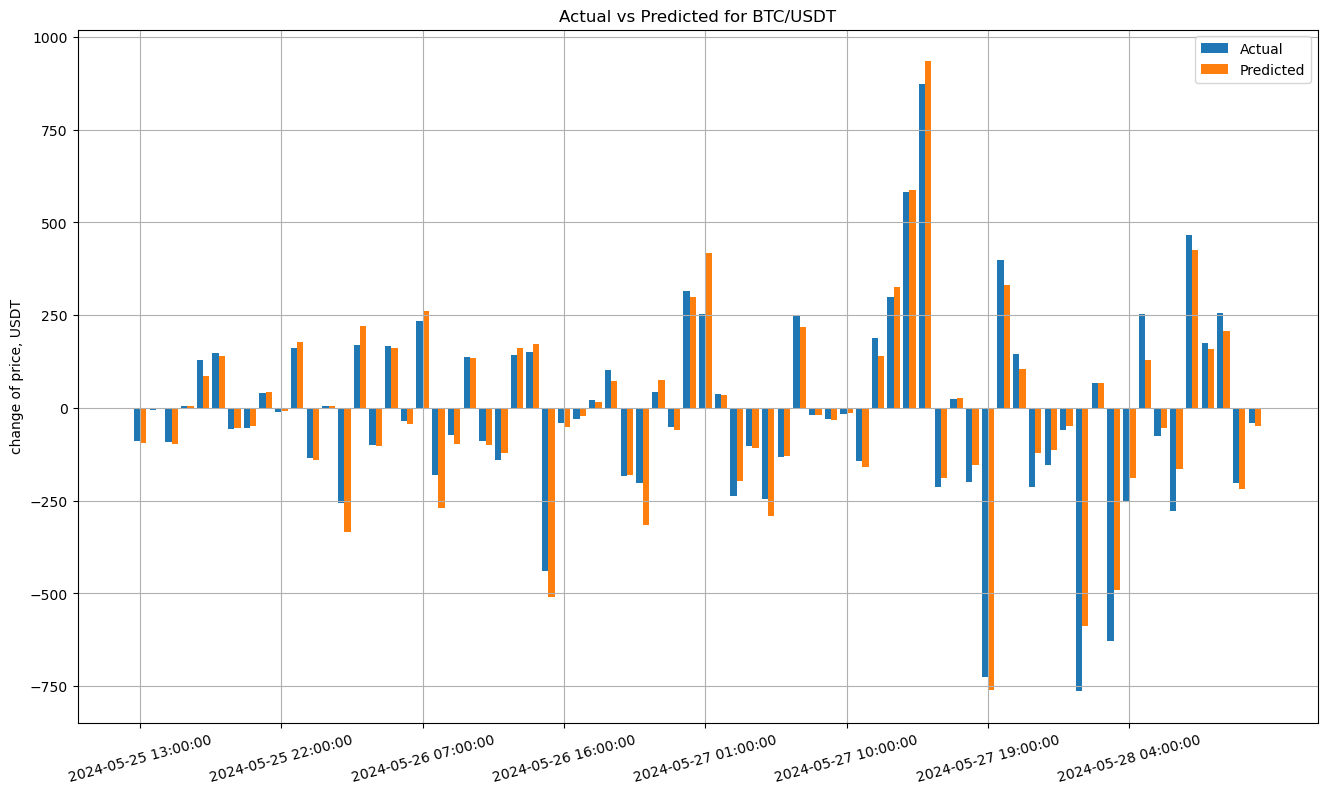

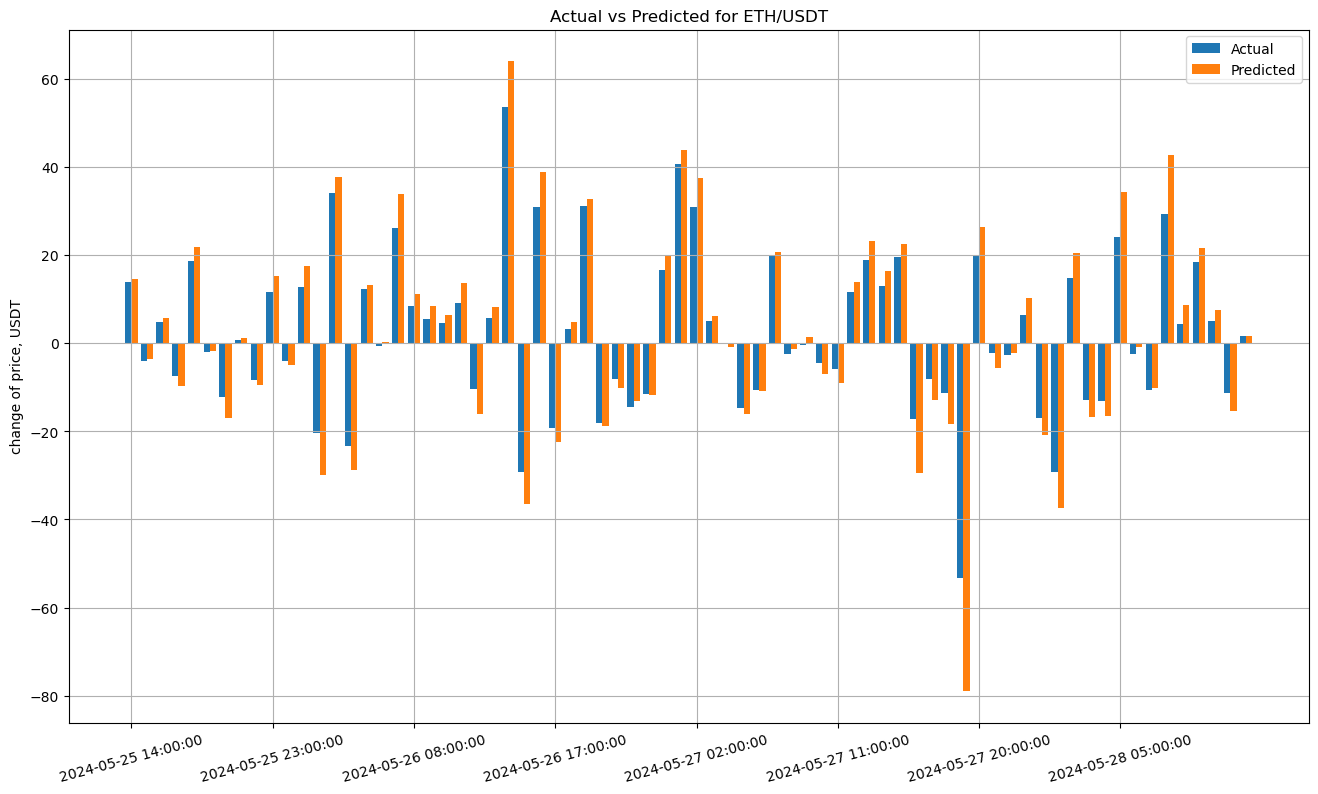

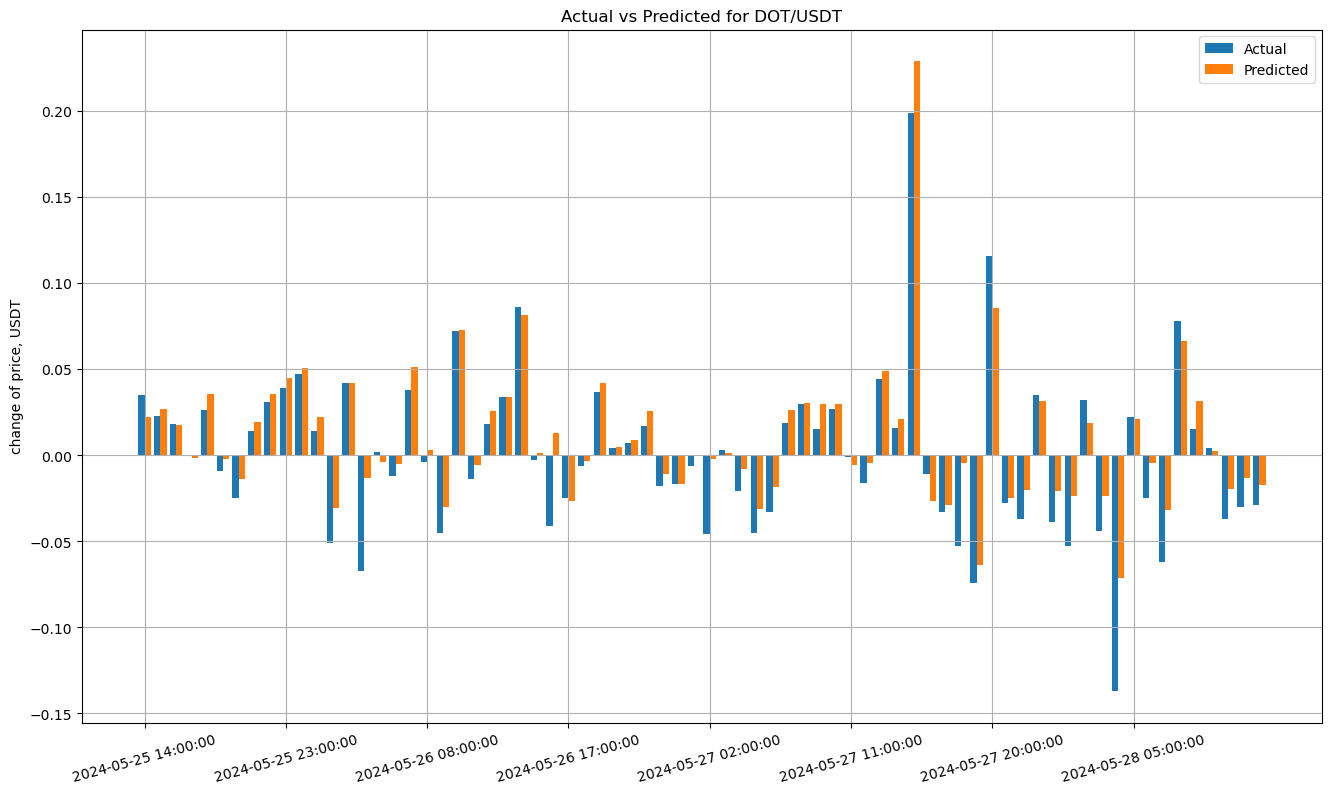

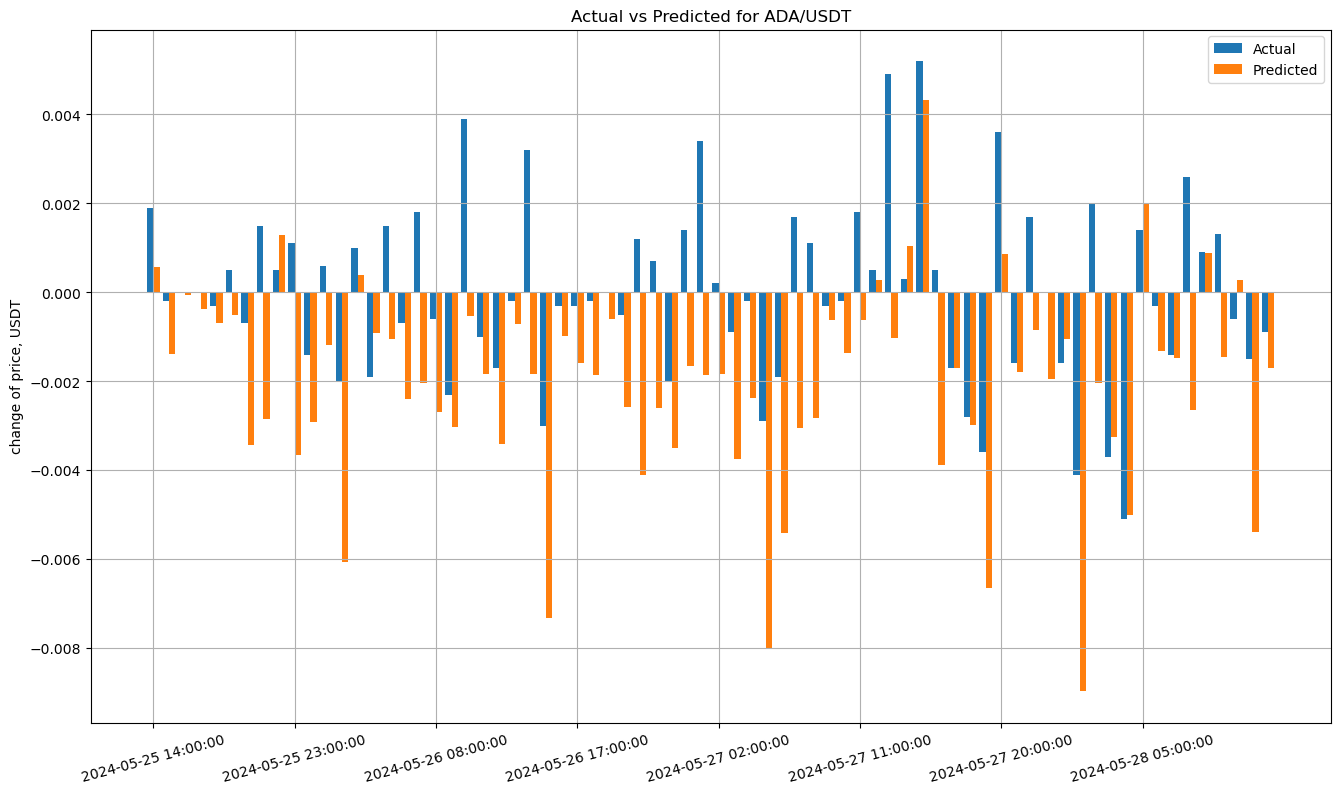

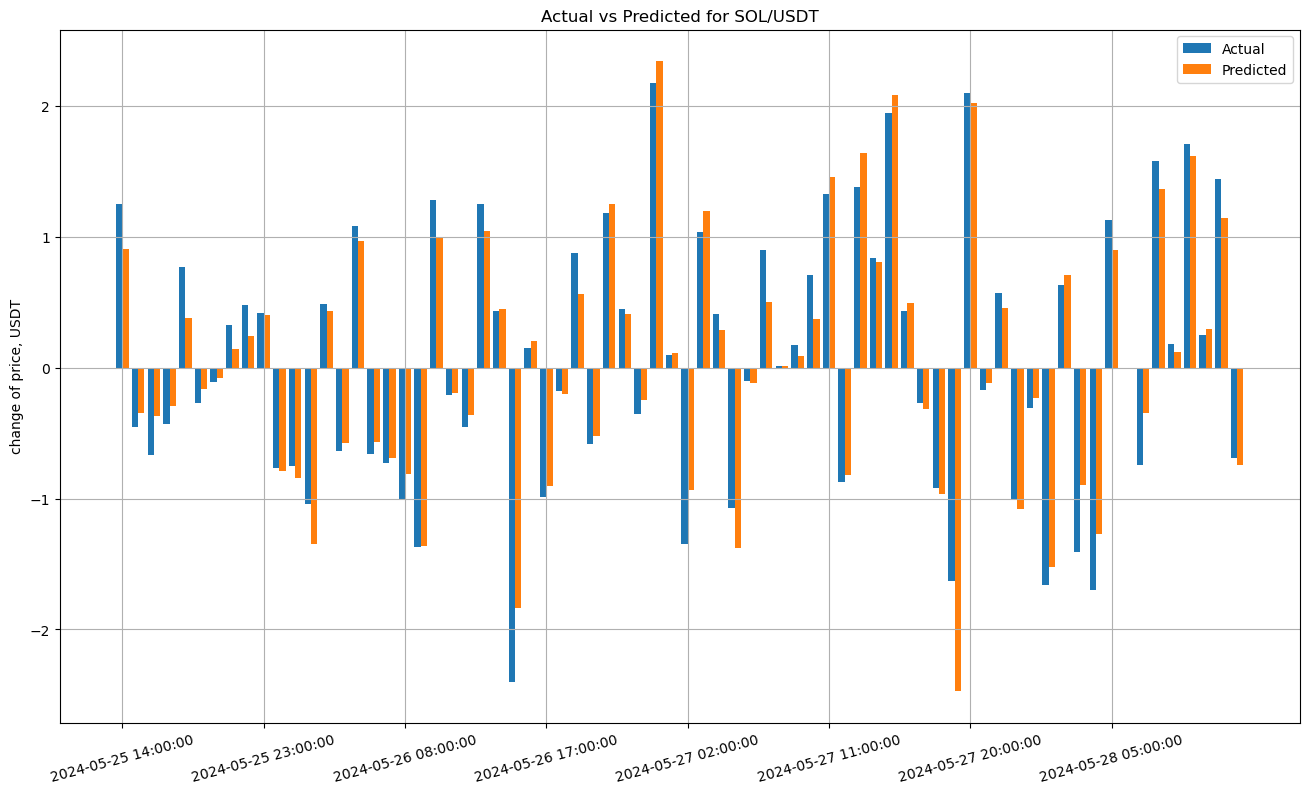

In [52]:
for symbol in symbols:
    temp_val = values[symbol]
    temp_pred = predictions[symbol]
    fig, ax = plt.subplots(figsize=(16, 9))
    last_n_frames = 72  # ostatnie 3 dni
    x_temp = np.arange(len(temp_val.index[-last_n_frames:]))
    w = 0.4
    ax.bar(x_temp - w/2, temp_val.iloc[-last_n_frames:], width=w, label="Actual")
    ax.bar(x_temp + w/2, temp_pred[-last_n_frames:], width=w, label="Predicted")
    ax.set_ylabel("change of price, USDT")
    ax.set_xticks(x_temp)
    ax.set_xticklabels(temp_val.index[-last_n_frames:].astype(str), rotation=15)
    plt.locator_params(axis="x", nbins=8)
    ax.grid(True)
    ax.set_title(f"Actual vs Predicted for {symbol}")
    ax.legend()
    plt.show()

## Różnica między faktyczną a przewidywaną zmianą 

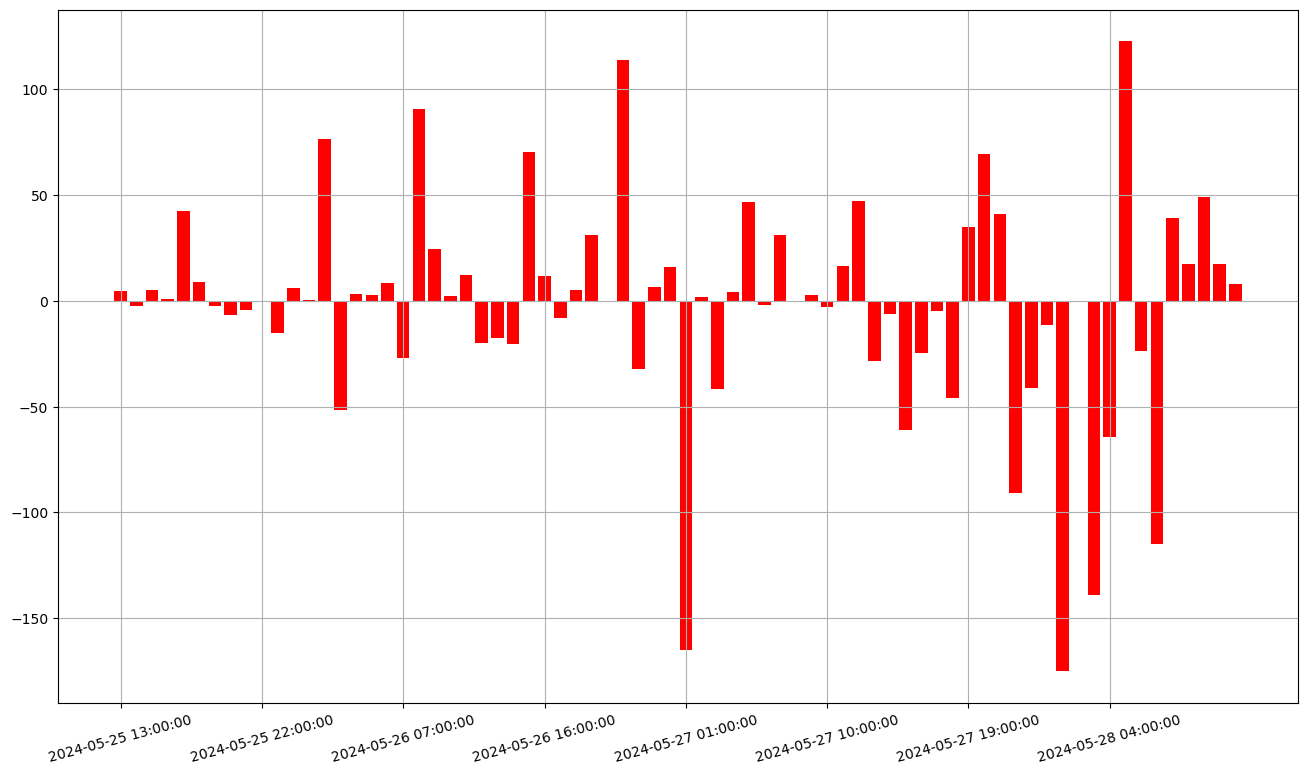

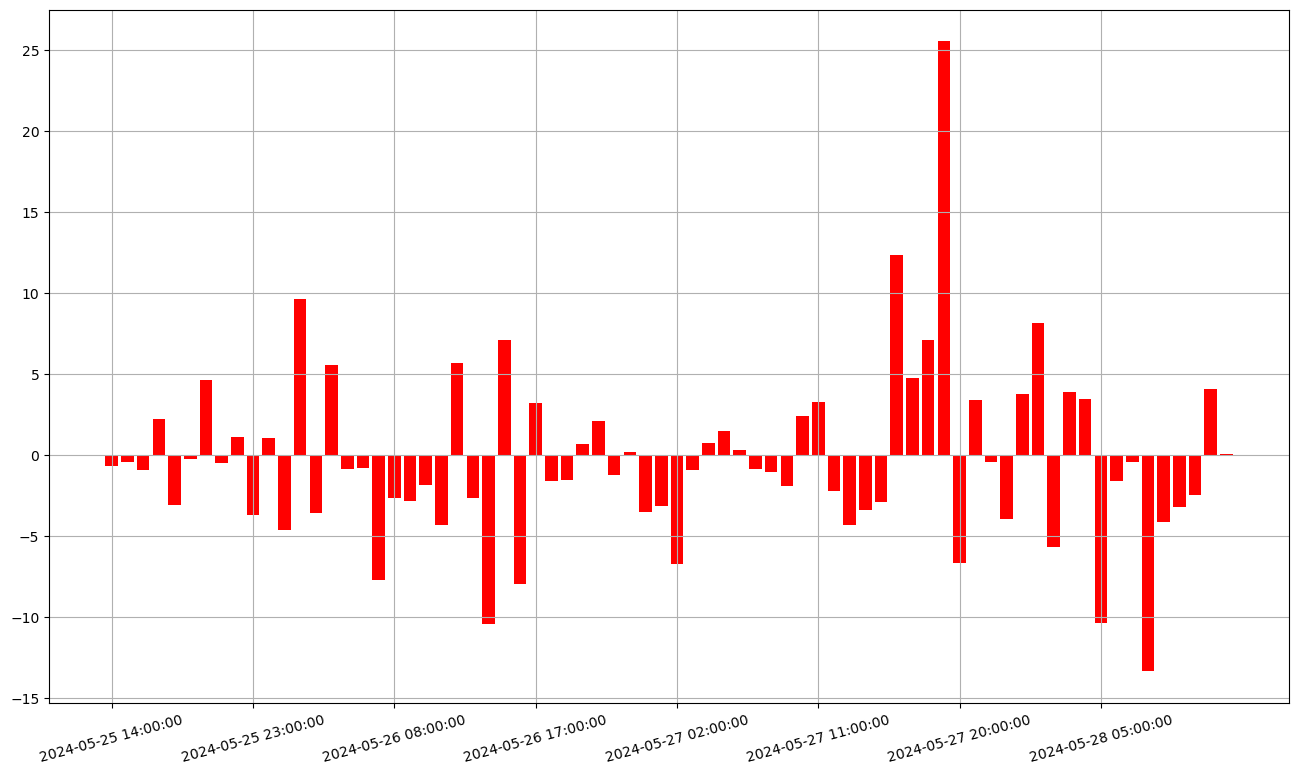

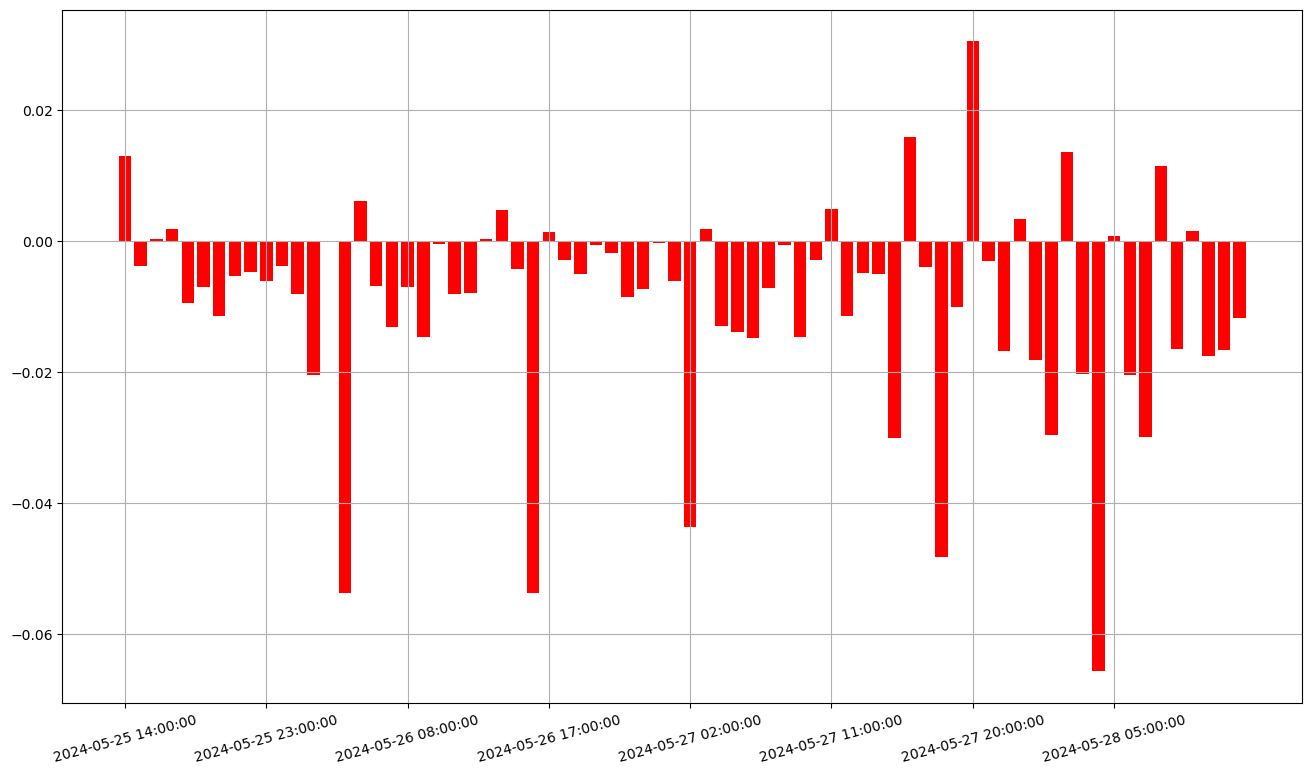

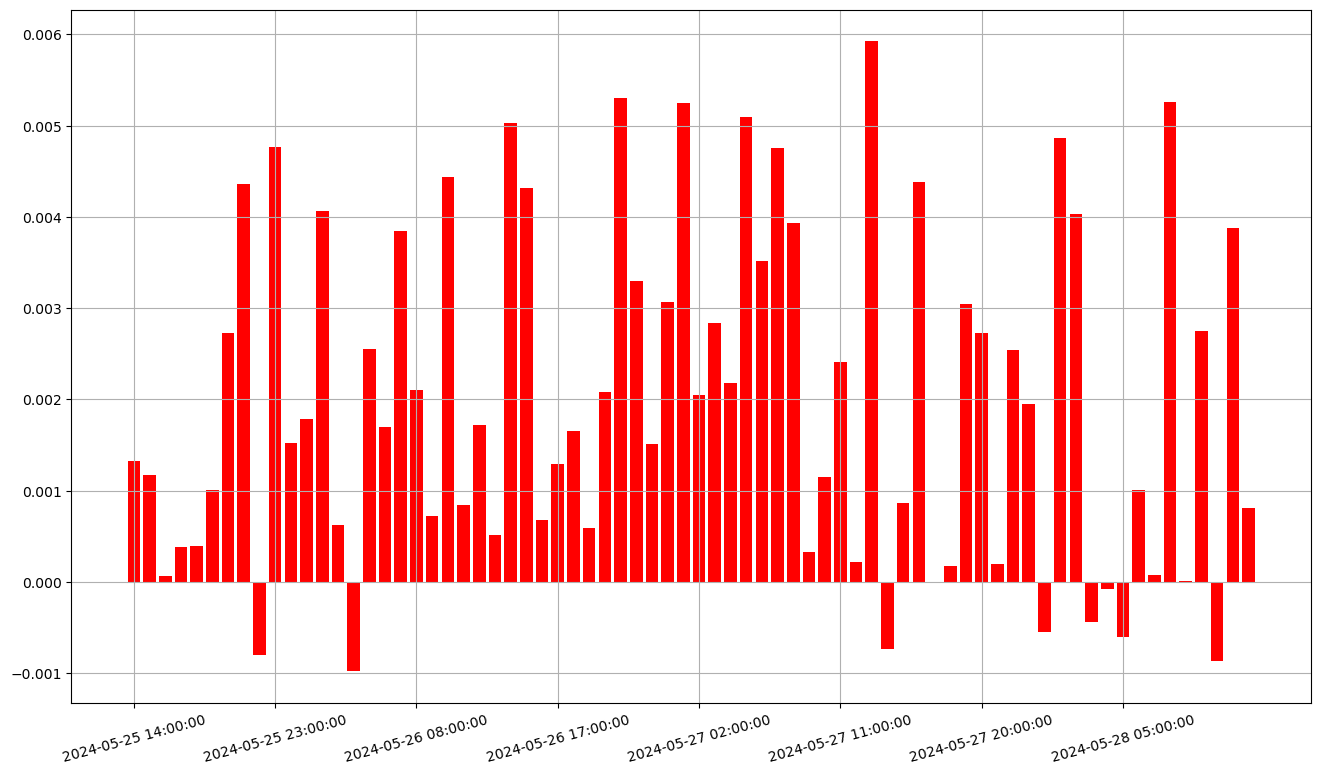

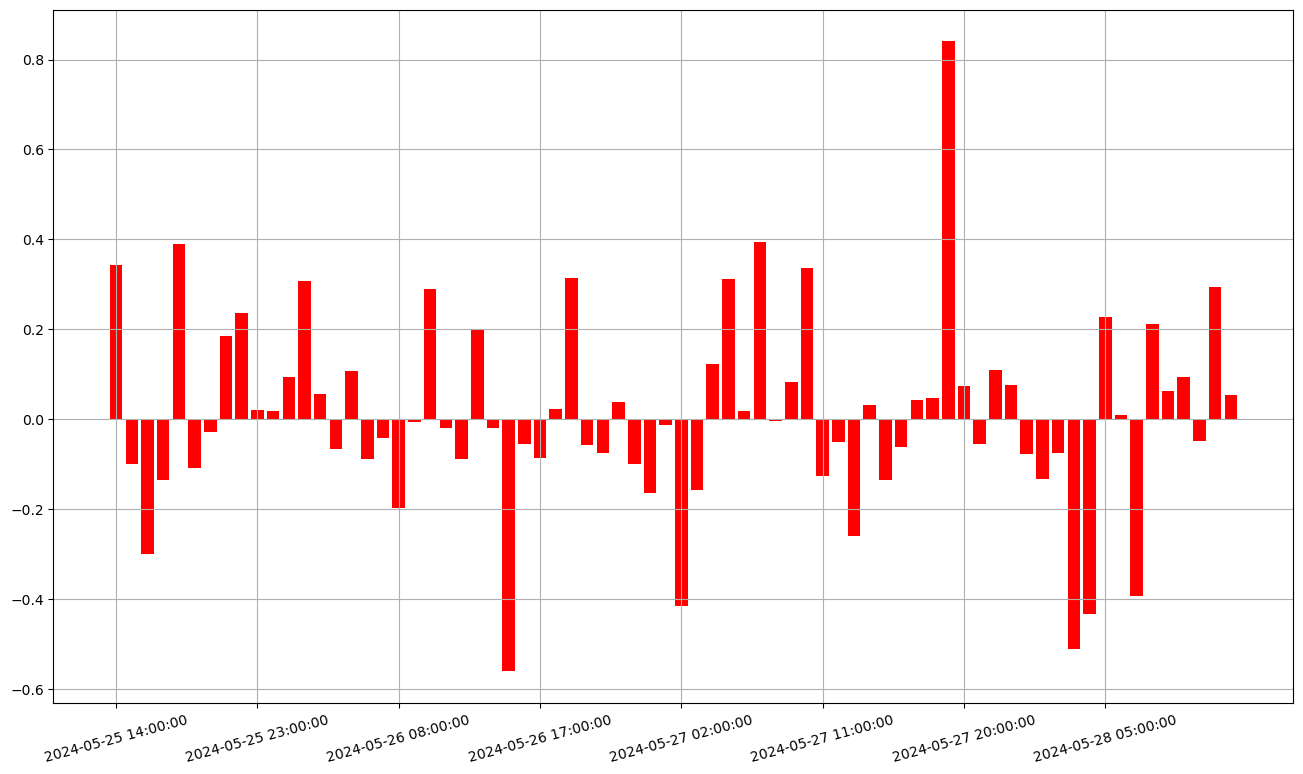

In [54]:
for symbol in symbols:
    temp_val = values[symbol]
    temp_pred = predictions[symbol]
    x_temp = np.arange(len(temp_val.index[-last_n_frames:]))
    fig, ax = plt.subplots(figsize=(16,9))
    ax.bar(x_temp[-72:], temp_val.iloc[-72:]-temp_pred[-72:], color="red")
    ax.set_xticks(x_temp[-72:])
    ax.set_xticklabels(temp_val.index[-72:].astype(str), rotation=15)
    ax.grid(True)
    plt.locator_params(axis="x", nbins=8)
    plt.show()

## wykres R2

[-28.298681361294207, -3.804993843435387, -6.094715749503439, -4.022284369039341, -3.4270433162106277, -2.4065190213605057, -3.9821053983443546, -4.644509064142903, -7.161263953409019, -4.267494664443057, -2.420816673545189, -3.909096791096724, -8.955026585320029, -4.7525362211748385, -4.218441478727207, -4.156510782911265, -7.19601859675655, -5.067728016254592, -15.970957650639, -12.353147474574236, -5.89522834575349, -4.604055449773729, -25.423260692313757, -8.019834433283043, -6.790282484257464, -3.600298865752391, -7.174934263905037, -8.188079769670274, -7.0486457051312374, -48.304934892005946, -18.861100377297813, -2.041904915706388, -1.9390720842380311, 0.13236295745083093, -0.688366834447427, -0.9253700203328721, 0.03981899040487258, 0.21657995437537791, -0.24178059360709625, -0.5541238064966691]


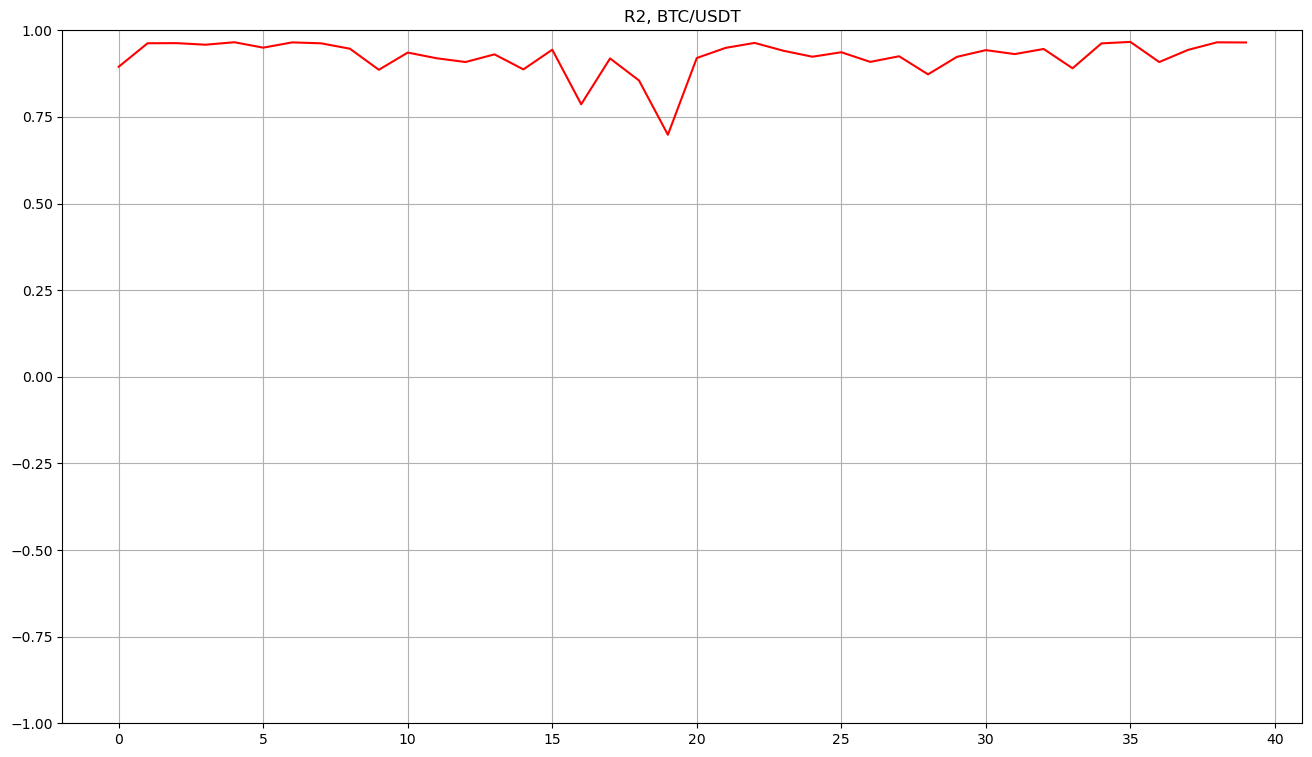

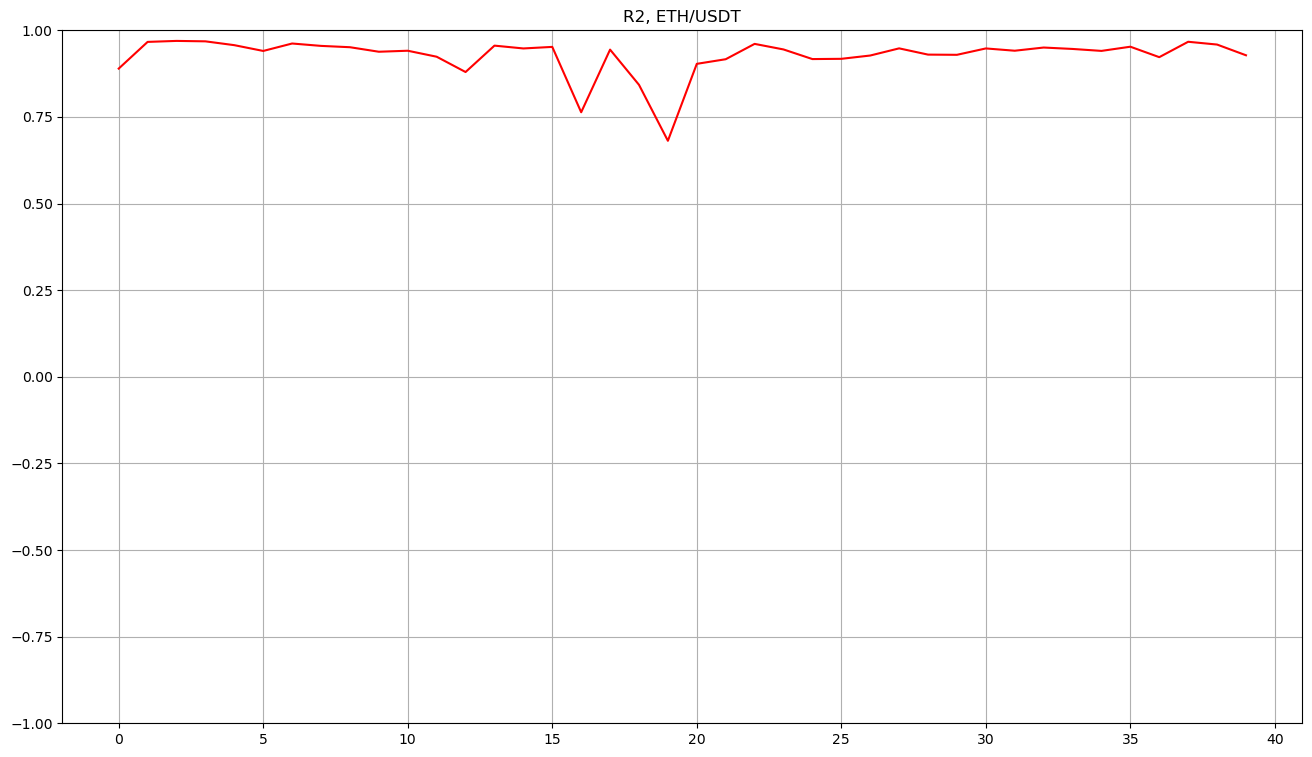

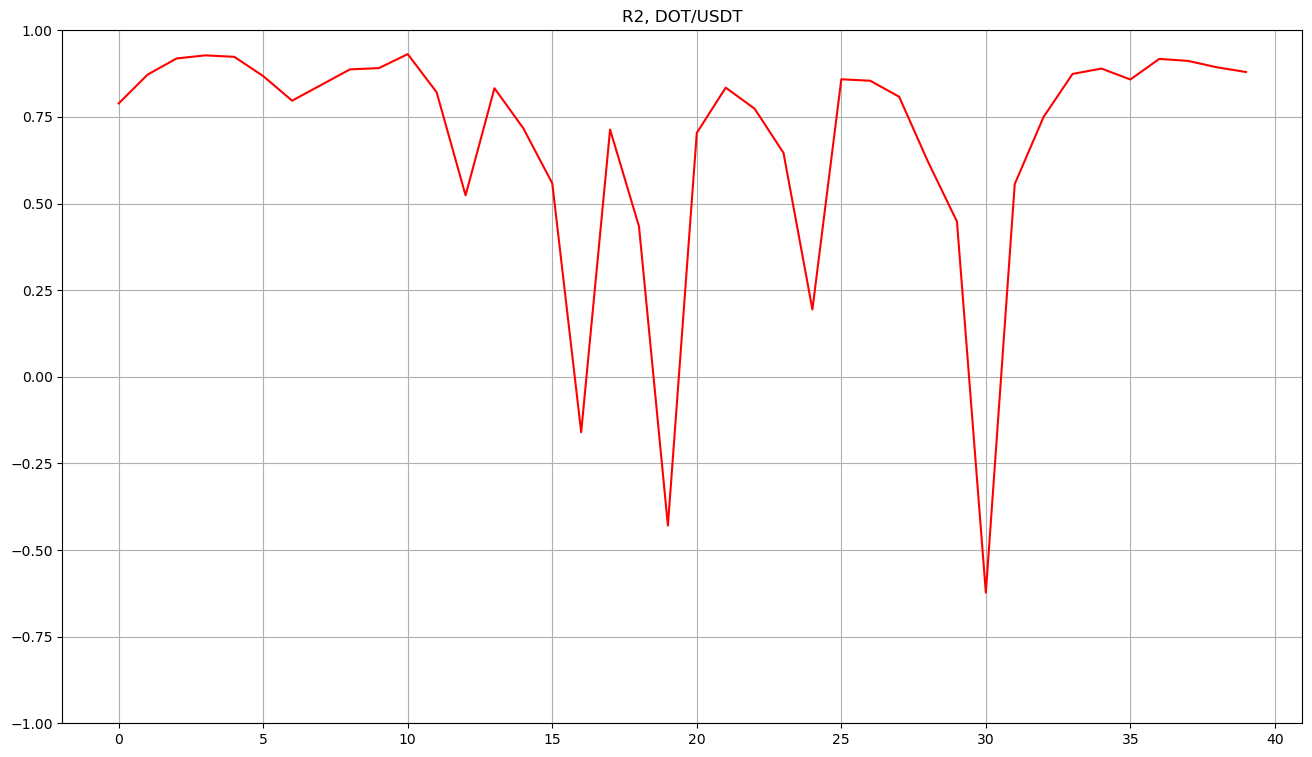

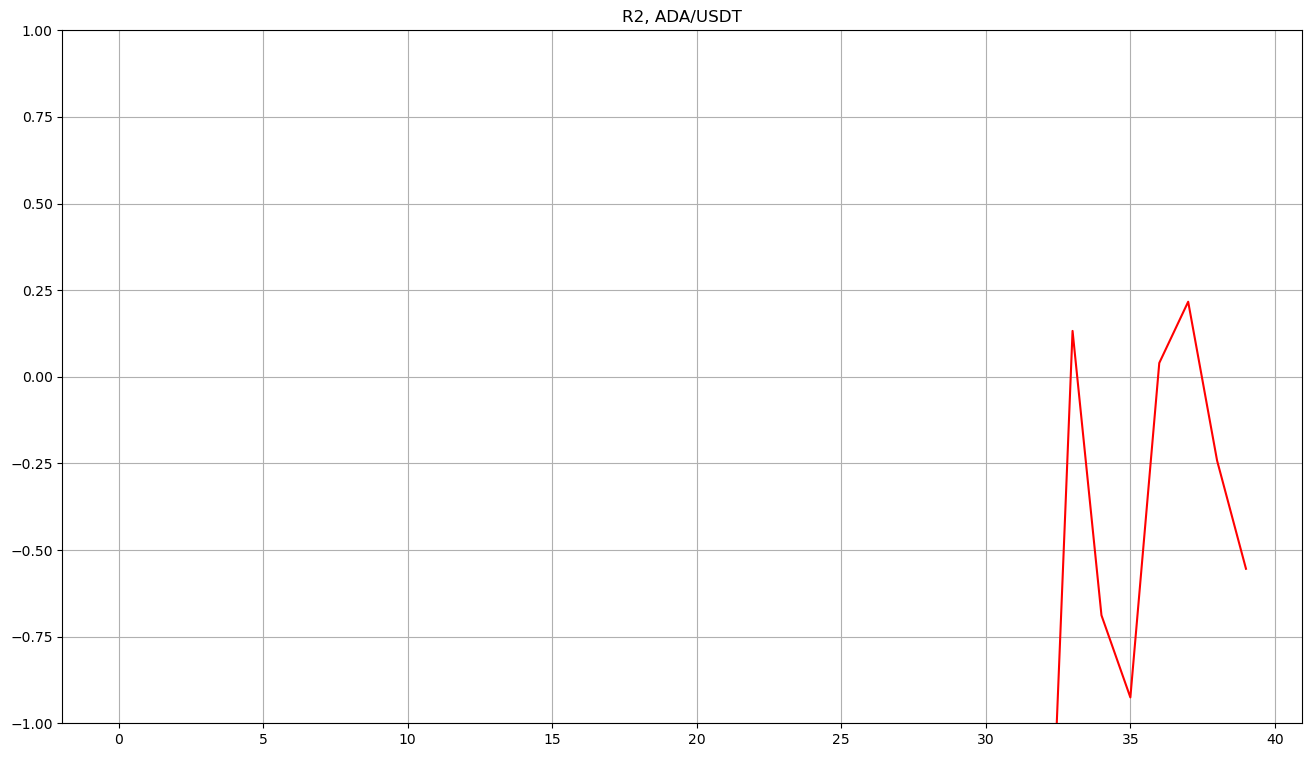

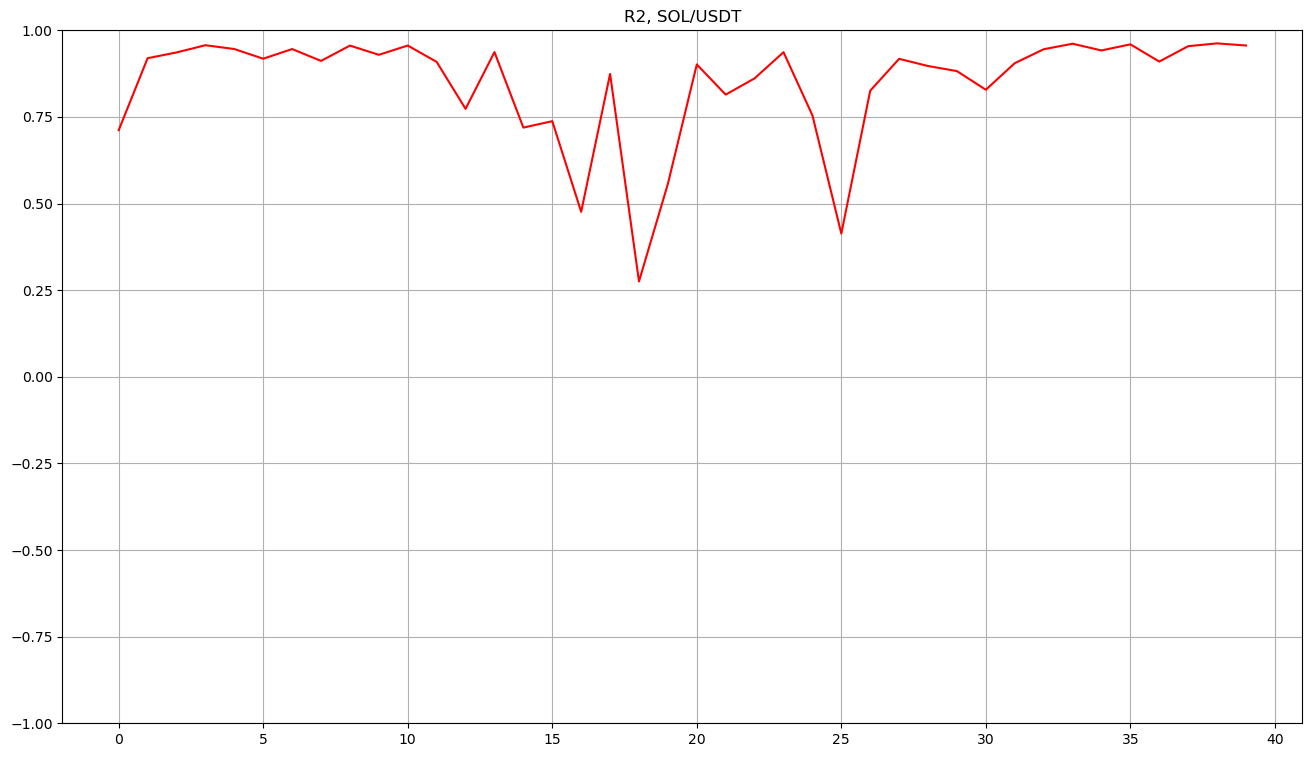

In [57]:
print(evaluations['ADA/USDT'][0])  # ADA/USDT ma wartości niżesze niż -1 (???)
for symbol in symbols:
    plt.figure(figsize=(16,9))
    plt.title(f"R2, {symbol}")
    plt.plot(evaluations[symbol][0], "r")
    plt.ylim([-1,1])
    plt.grid(True)
    plt.show()

## porównanie RSS i MAE

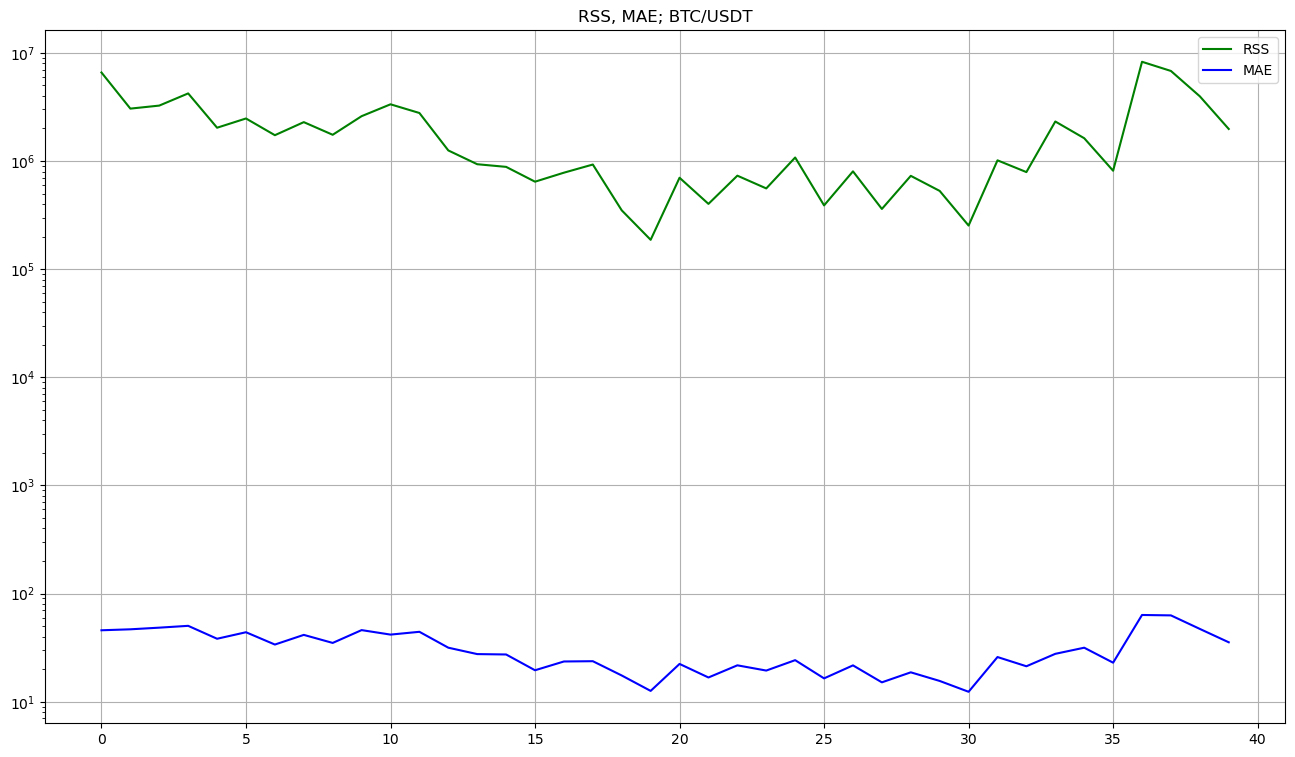

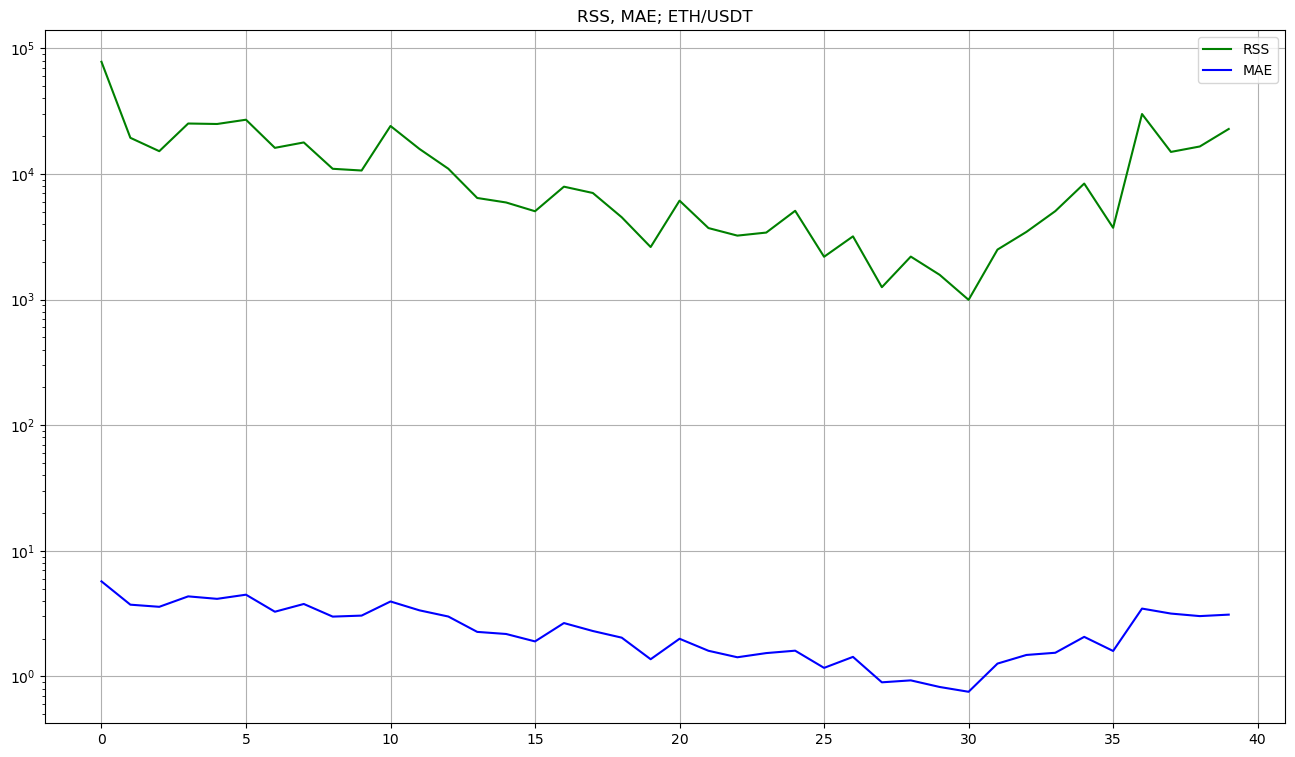

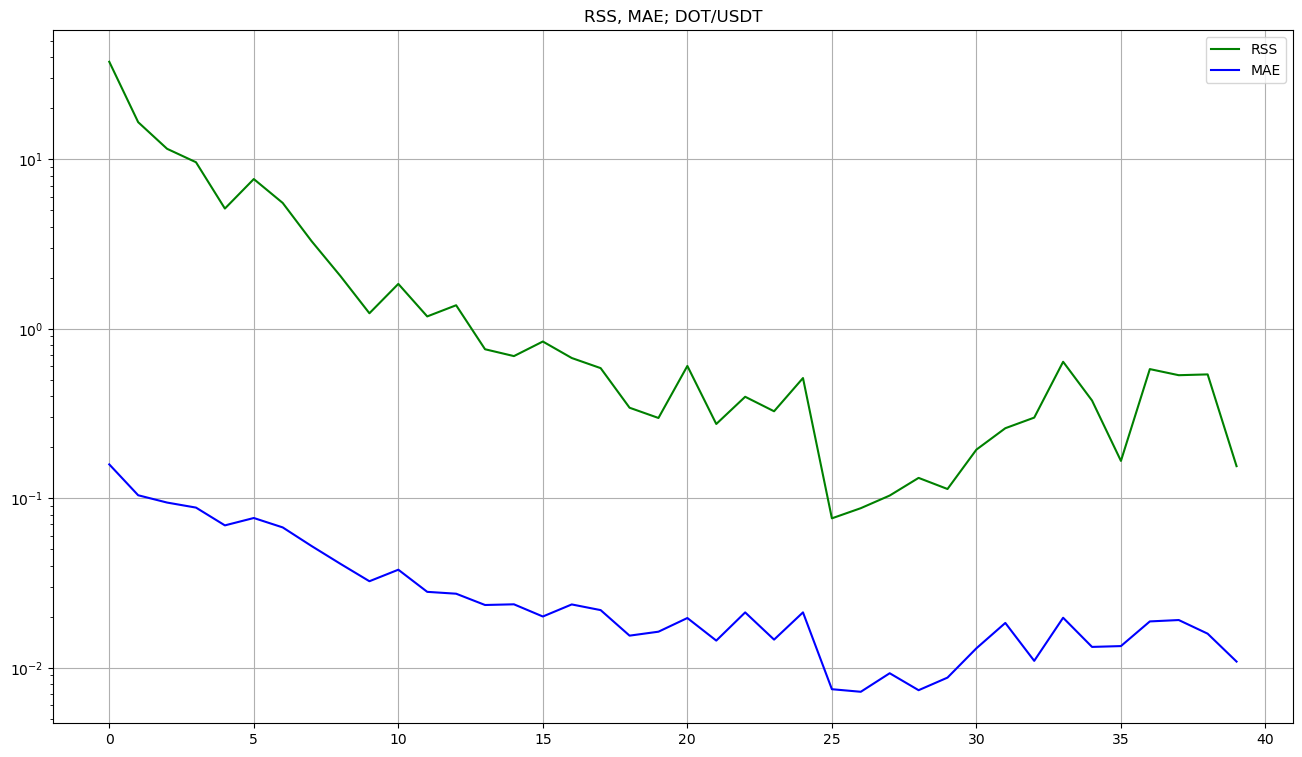

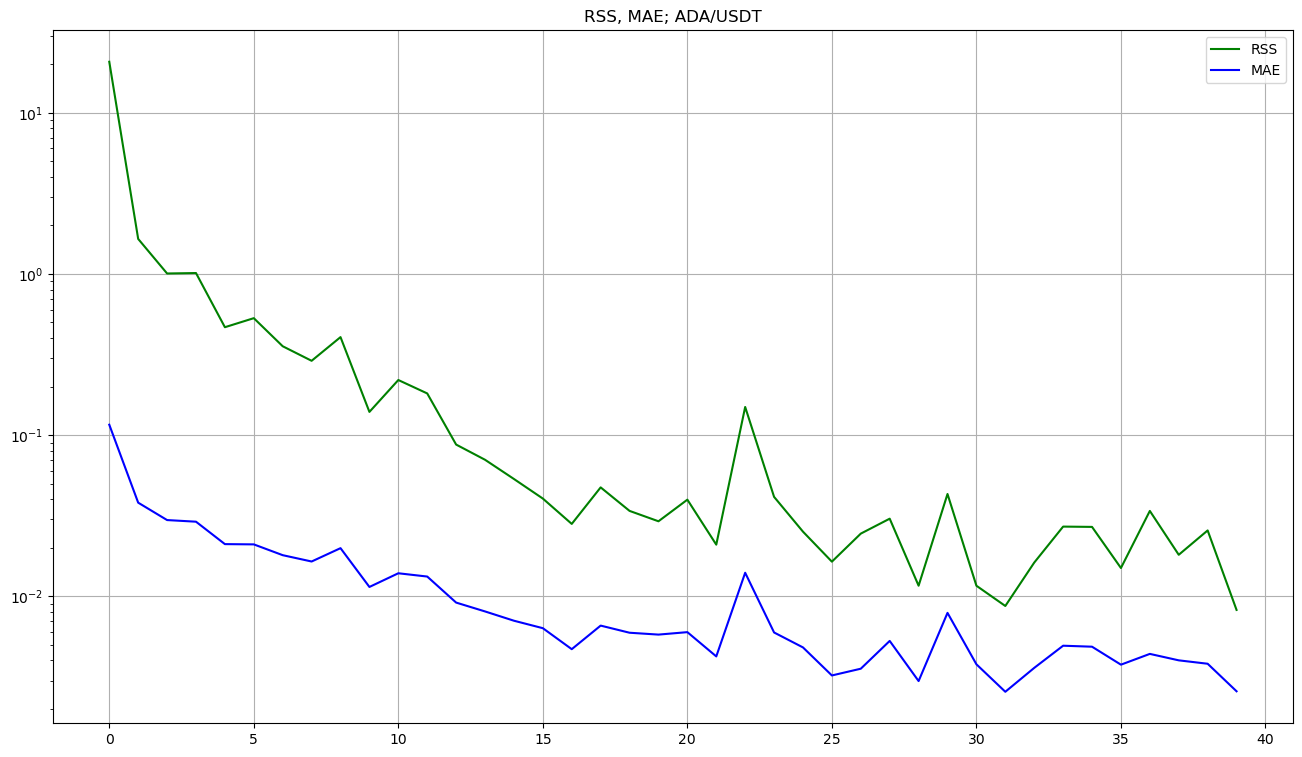

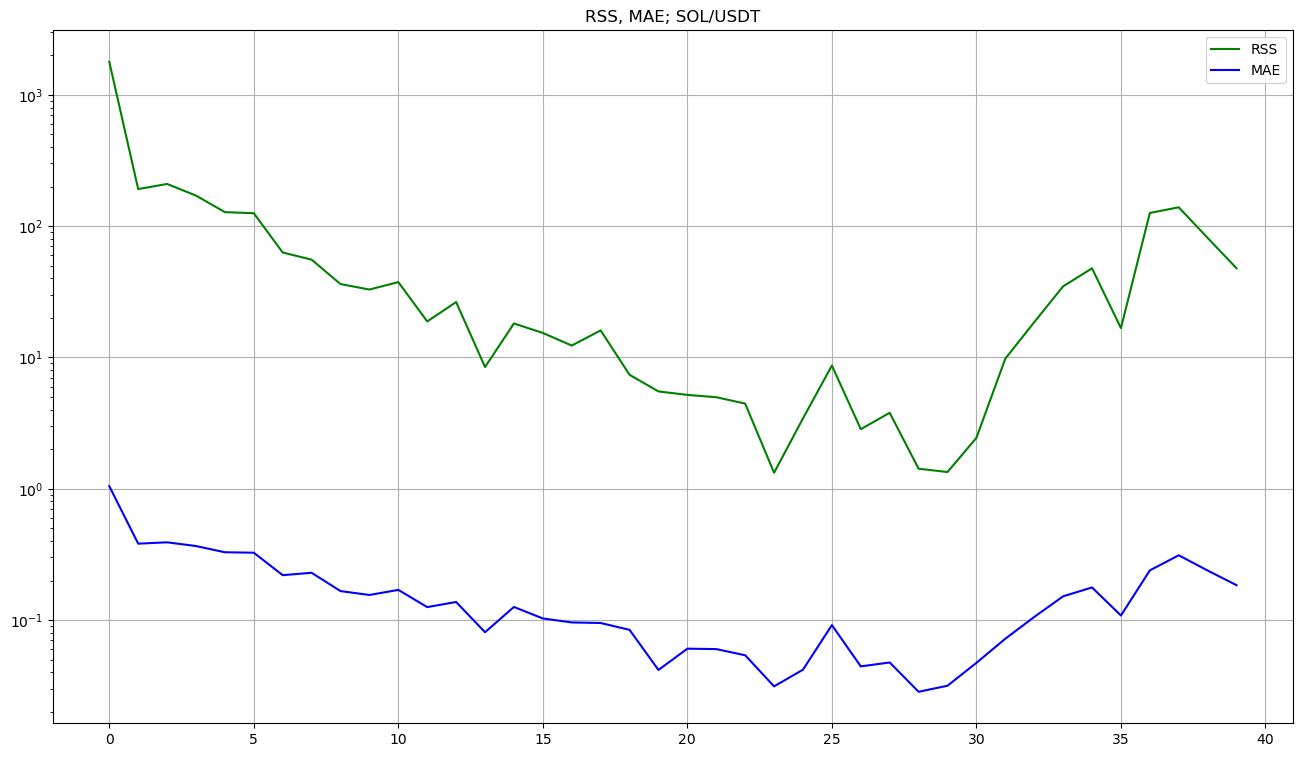

In [58]:
for symbol in symbols:
    plt.figure(figsize=(16,9))
    plt.title(f"RSS, MAE; {symbol}")
    plt.plot(evaluations[symbol][1], "g")
    plt.plot(evaluations[symbol][2], "b")
    plt.yscale("log")
    plt.legend(["RSS", "MAE"])
    plt.grid(True)
    plt.show()

## wykres funkcji straty

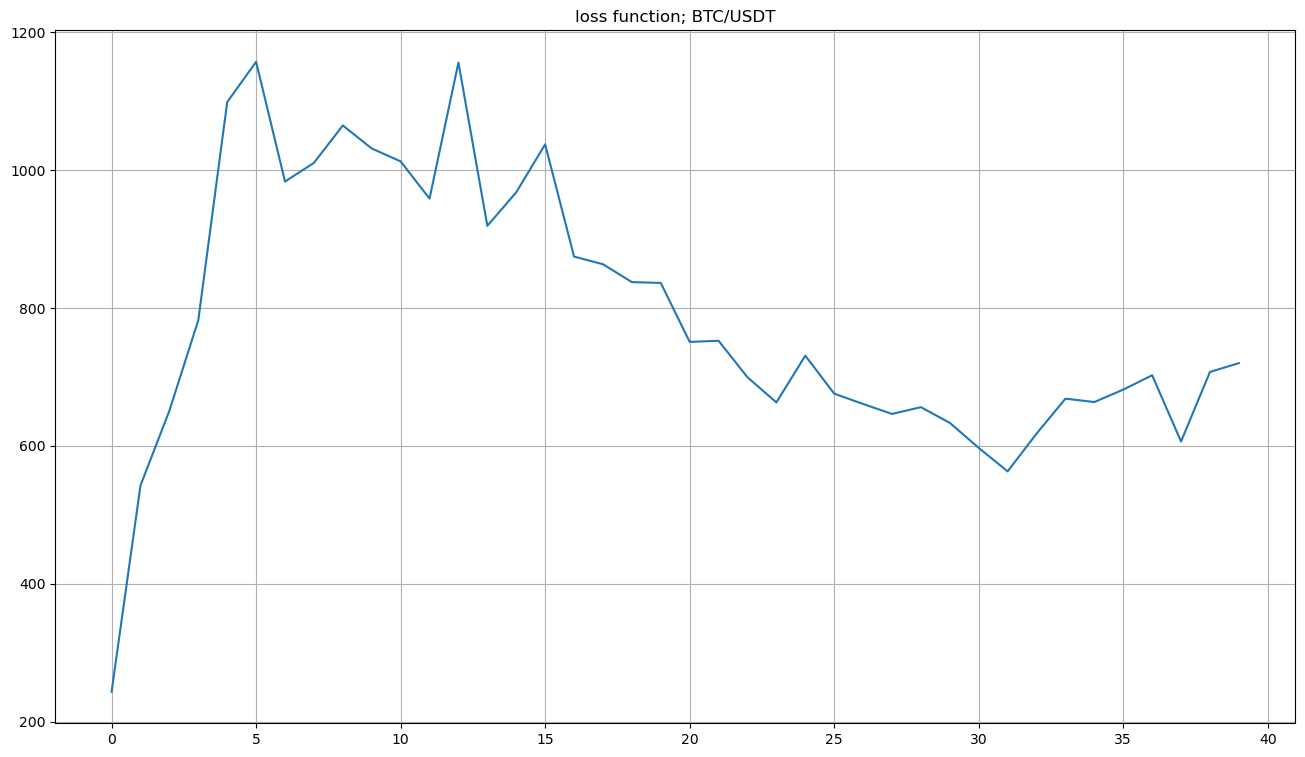

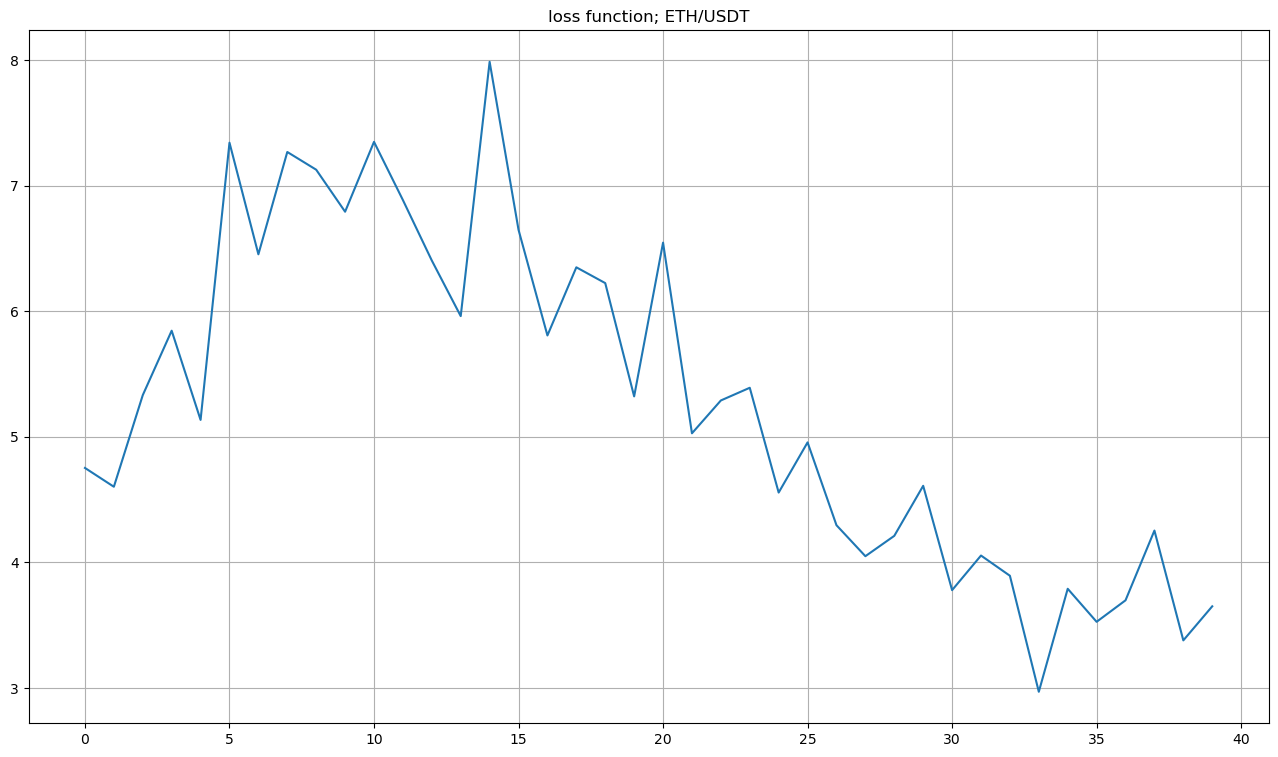

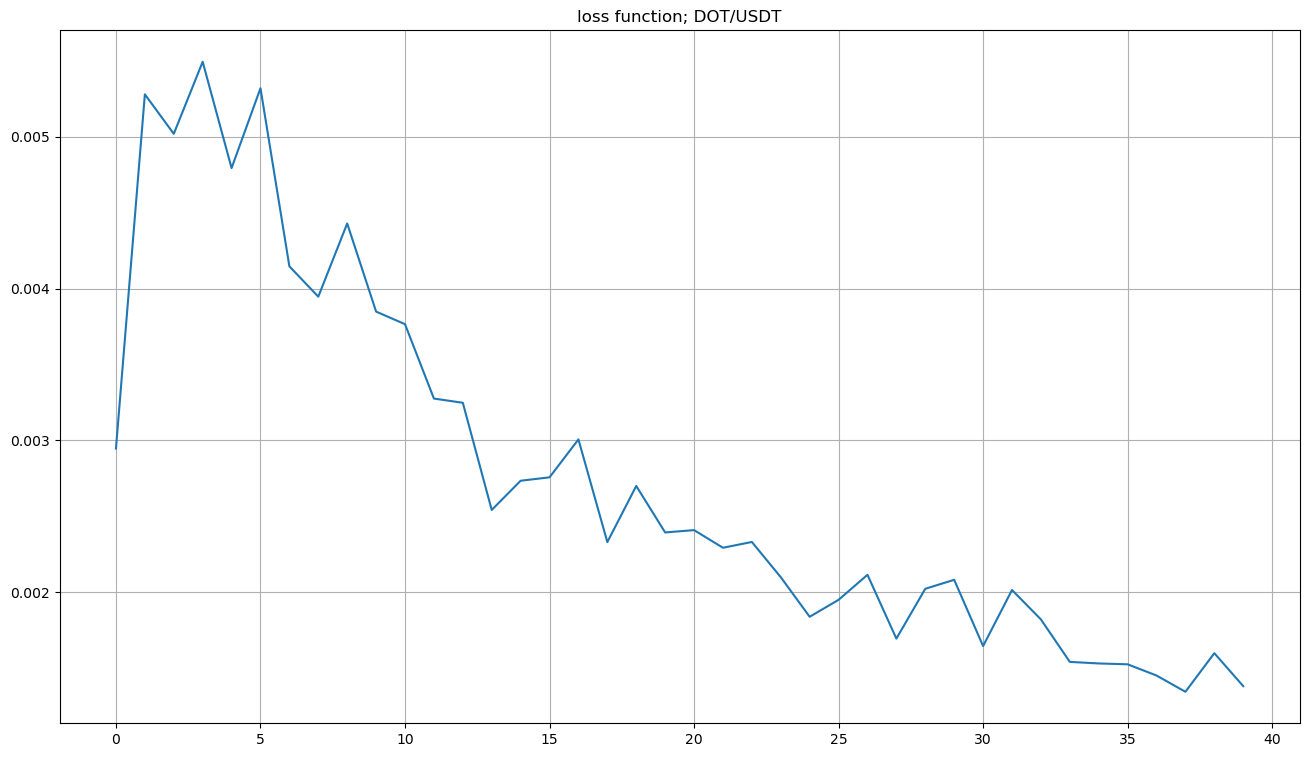

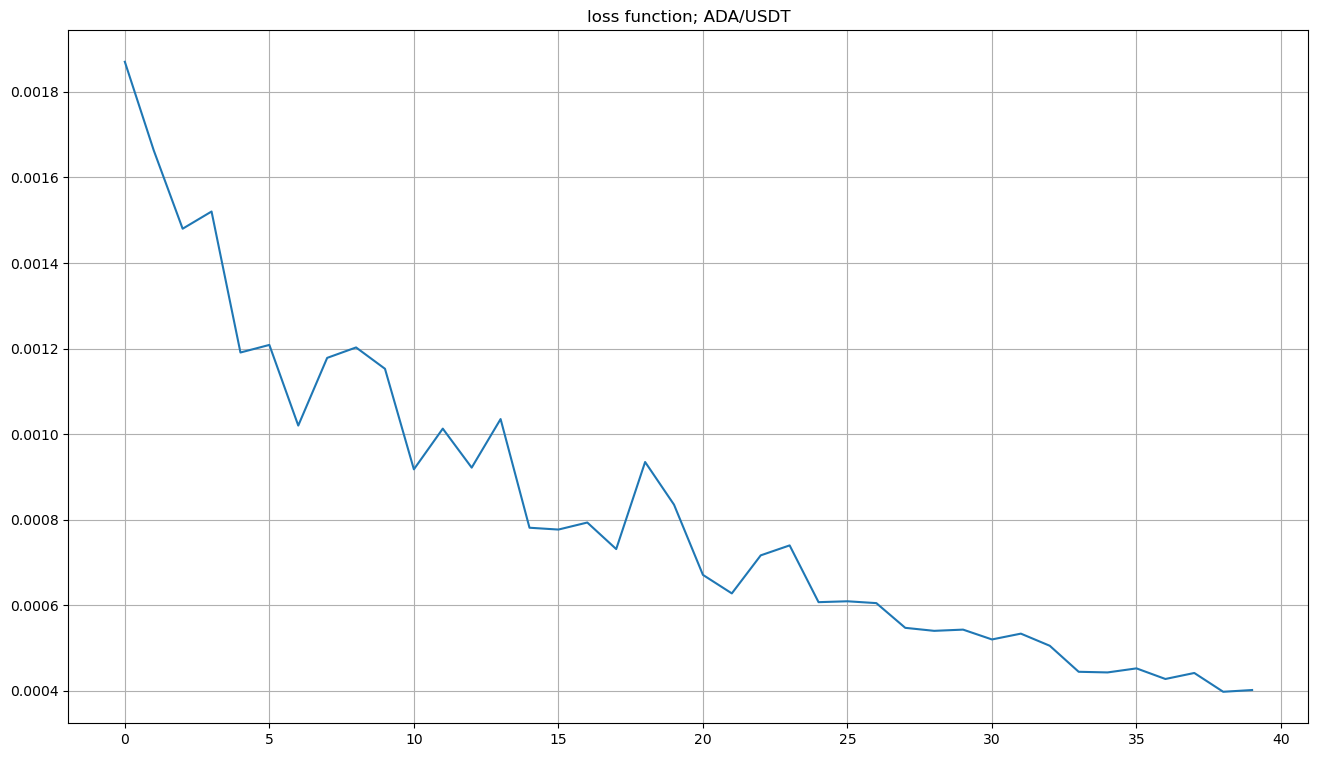

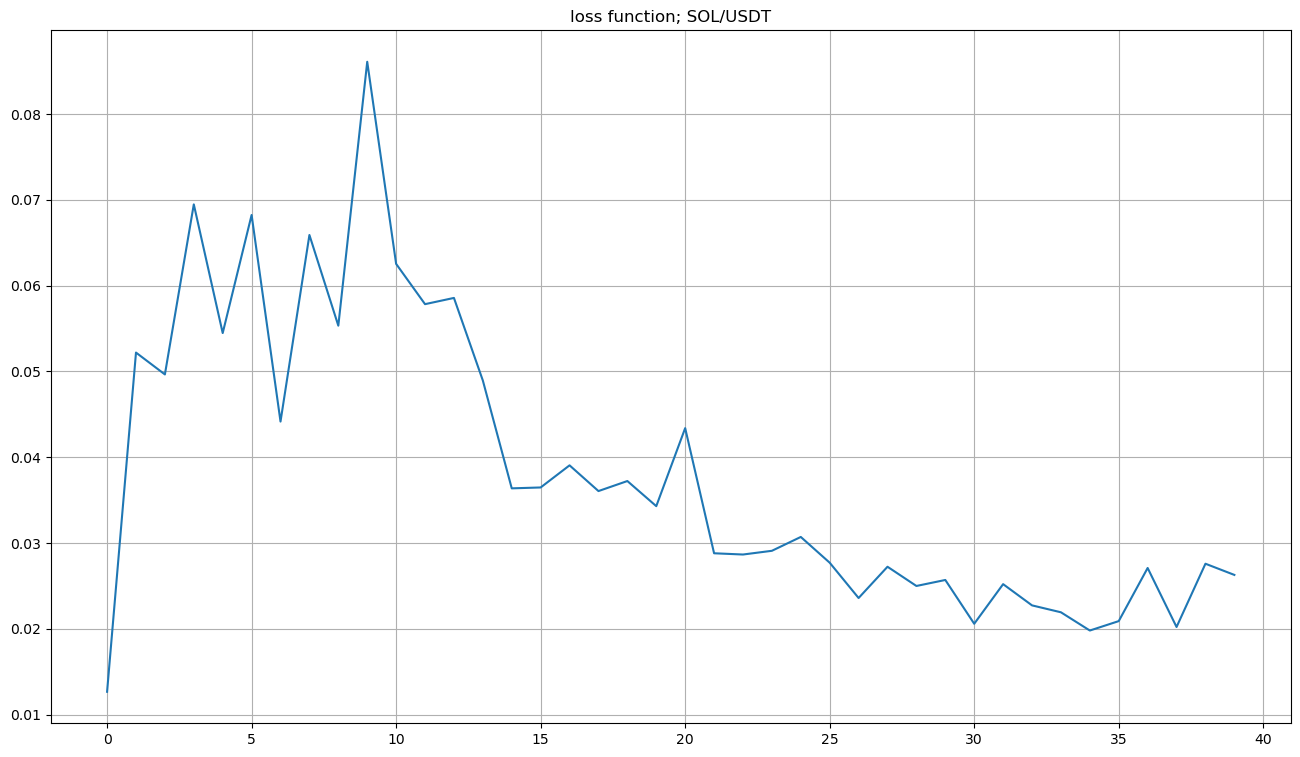

In [59]:
for symbol in symbols:
    plt.figure(figsize=(16,9))
    plt.title(f"loss function; {symbol}")
    plt.plot(evaluations[symbol][3])
    plt.grid(True)
    plt.show()

# **wizualizacja - Cross-Validation, K-fold**

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\3379696891.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\3379696891.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


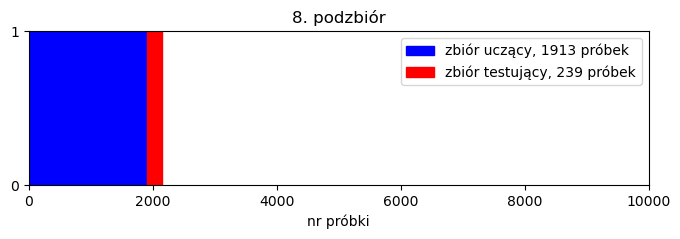

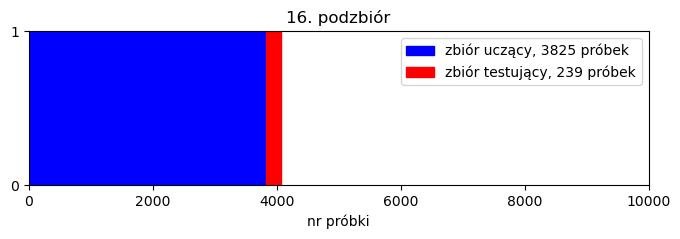

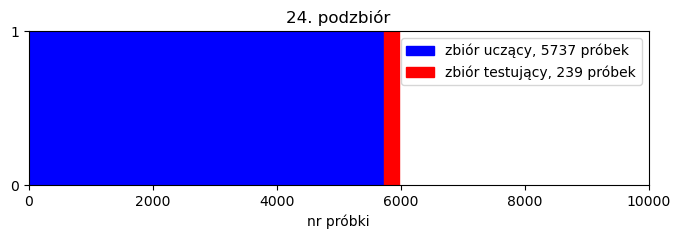

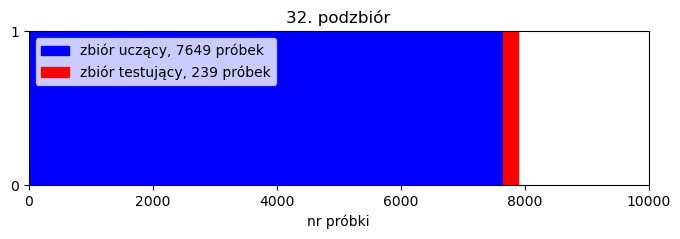

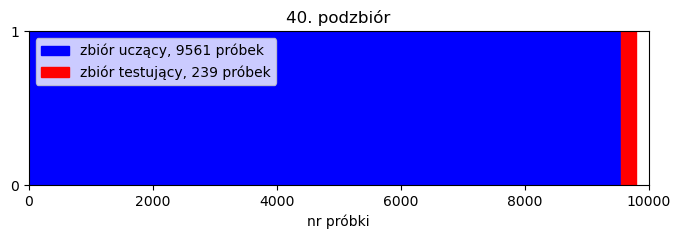

In [16]:
dataframe = fetch_ohlcv(symbols[0], timeframe=timeframe, n_frames=n_hours)
dataframe = dataframe.diff()
dataframe = dataframe.dropna()
X = dataframe.drop(['close'], axis=1)

tscv = TimeSeriesSplit(n_splits=40)
for i, (train_ind, test_ind) in enumerate(tscv.split(X)):
    if (i%8==7):
        fig, ax = plt.subplots(figsize=(8,2))
        ax.set_title(f"{i+1}. podzbiór")
        ax.axvspan(train_ind[0], test_ind[0], color="b")
        ax.axvspan(test_ind[0], test_ind[-1], color="r")
        ax.set_xlim([0,n_hours])
        #ax.set_xlim([0,(n_hours*(i+2)/40)])
        ax.set_xlabel("nr próbki")
        ax.set_yticks([0,1])
        ax.legend([f"zbiór uczący, {len(train_ind)} próbek", f"zbiór testujący, {len(test_ind)} próbek"])
        plt.show

# macierze korelacji

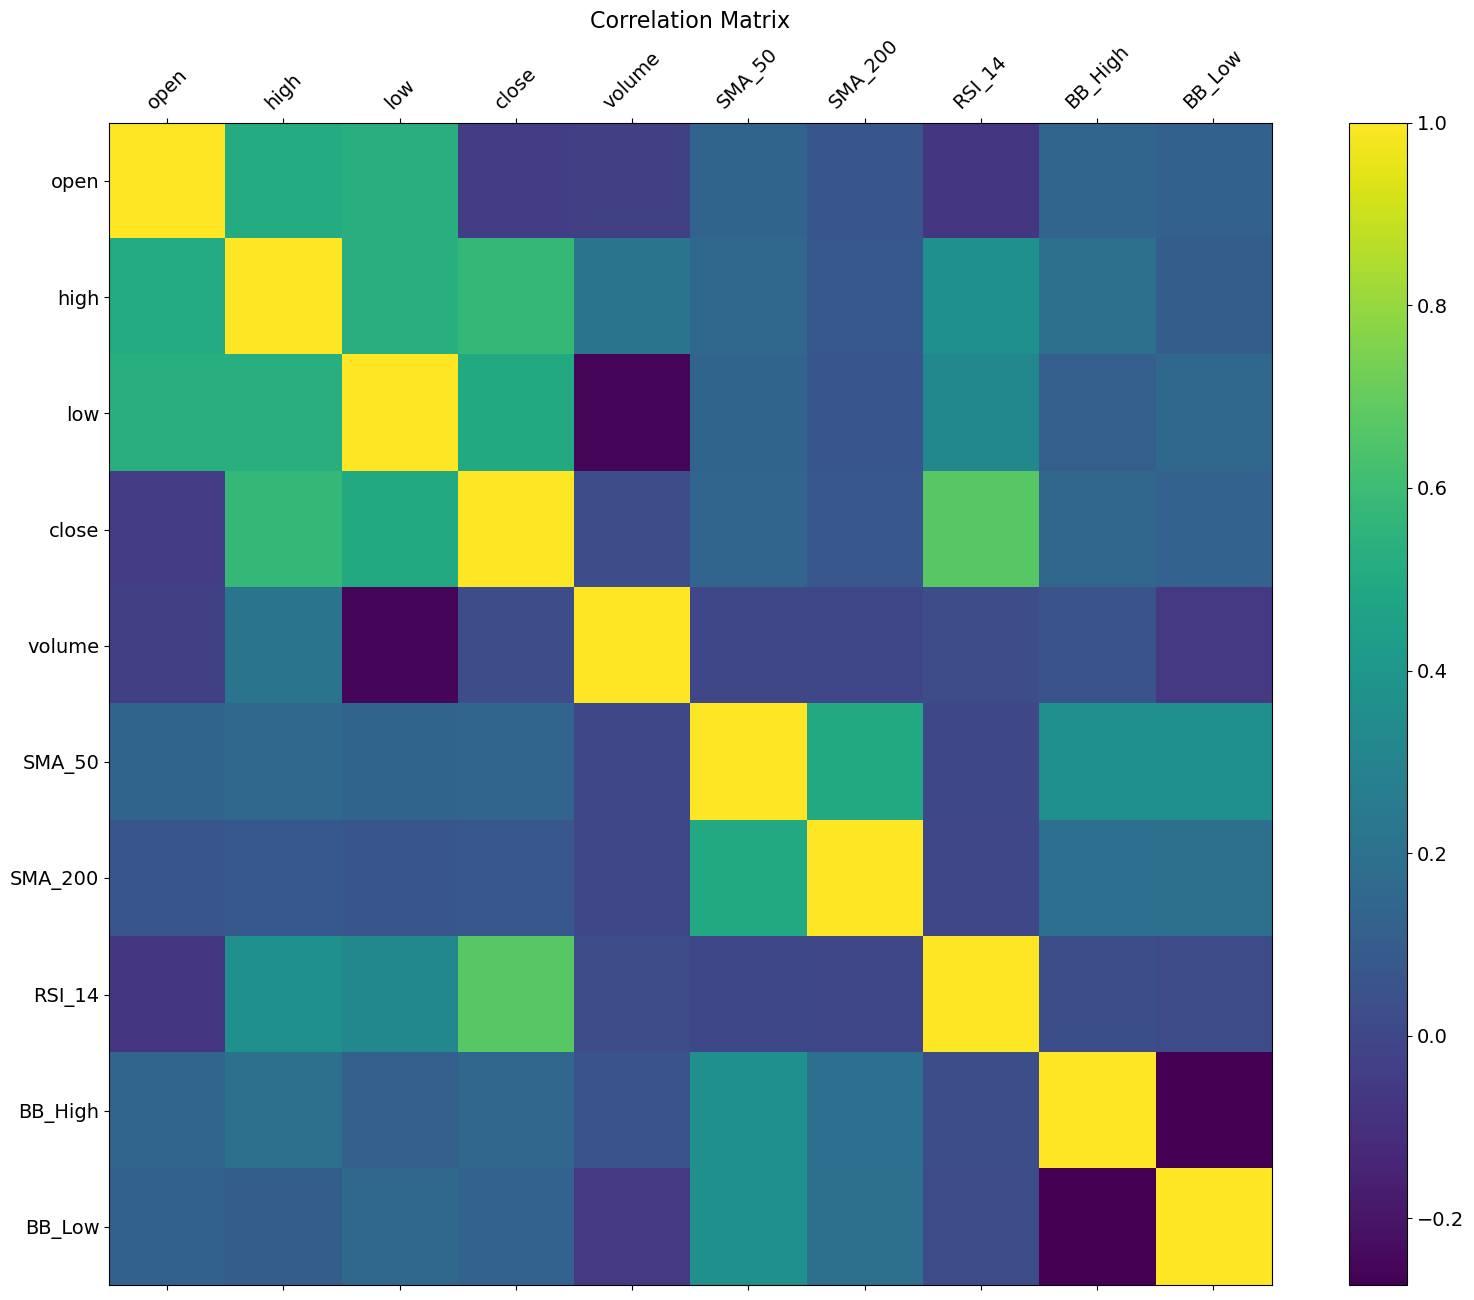

In [60]:
def plot_correlation(df):
    f = plt.figure(figsize=(20, 15))
    ax = plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #ax.set_ylim([0,2])
    plt.title('Correlation Matrix', fontsize=16);
    
corr=dataframe.corr()
plot_correlation(dataframe)

In [61]:
corr.style.background_gradient(cmap='coolwarm')

,open,high,low,close,volume,SMA_50,SMA_200,RSI_14,BB_High,BB_Low
open,1.000000,0.511288,0.525586,-0.043864,-0.031210,0.136013,0.067486,-0.071226,0.143386,0.120093
high,0.511288,1.000000,0.525183,0.574017,0.216145,0.158890,0.077753,0.366153,0.196876,0.101969
low,0.525586,0.525183,1.000000,0.499855,-0.254963,0.138733,0.068728,0.322482,0.111838,0.156039
close,-0.043864,0.574017,0.499855,1.000000,0.026392,0.143310,0.070551,0.671557,0.145740,0.126569
volume,-0.031210,0.216145,-0.254963,0.026392,1.000000,-0.000727,-0.000708,0.025730,0.060042,-0.061710
SMA_50,0.136013,0.158890,0.138733,0.143310,-0.000727,1.000000,0.500099,0.005403,0.368295,0.364692
SMA_200,0.067486,0.077753,0.068728,0.070551,-0.000708,0.500099,1.000000,-0.000617,0.191583,0.197834
RSI_14,-0.071226,0.366153,0.322482,0.671557,0.025730,0.005403,-0.000617,1.000000,0.031561,0.018013
BB_High,0.143386,0.196876,0.111838,0.145740,0.060042,0.368295,0.191583,0.031561,1.000000,-0.273082
BB_Low,0.120093,0.101969,0.156039,0.126569,-0.061710,0.364692,0.197834,0.018013,-0.273082,1.000000
